In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas_datareader import data


In [2]:
data_inicio = '2000-01-01'
data_fim = '2015-09-22'

In [3]:
df = data.DataReader('abev3.sa', 'yahoo', data_inicio, data_fim)
df['Date'] = df.index
df

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2000-01-05,0.520882,0.520882,0.520882,0.520882,985.0,0.334178,2000-01-05
2000-01-06,0.494478,0.494478,0.494478,0.494478,227.0,0.317238,2000-01-06
2000-01-07,0.494478,0.494478,0.494478,0.494478,151.0,0.317238,2000-01-07
2000-01-10,0.494478,0.494478,0.494478,0.494478,1516.0,0.317238,2000-01-10
2000-01-11,0.494478,0.494478,0.494478,0.494478,3791.0,0.317238,2000-01-11
...,...,...,...,...,...,...,...
2015-09-16,19.629999,19.219999,19.500000,19.450001,33098100.0,16.559687,2015-09-16
2015-09-17,19.770000,19.260000,19.270000,19.490000,15112200.0,16.593740,2015-09-17
2015-09-18,19.770000,19.219999,19.299999,19.469999,17755500.0,16.576712,2015-09-18


In [4]:
df['mm5D'] = df['Close'].rolling(5).mean()
df['mm21D'] = df['Close'].rolling(21).mean()

In [5]:
df_close = df[['Close', 'Open', 'High', 'Low']]

In [6]:
df_close.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [7]:
df_close

,Close,Open,High,Low
Date,,,,
2000-01-05,0.520882,0.520882,0.520882,0.520882
2000-01-06,0.494478,0.494478,0.494478,0.494478
2000-01-07,0.494478,0.494478,0.494478,0.494478
2000-01-10,0.494478,0.494478,0.494478,0.494478
2000-01-11,0.494478,0.494478,0.494478,0.494478
...,...,...,...,...
2015-09-16,19.450001,19.500000,19.629999,19.219999
2015-09-17,19.490000,19.270000,19.770000,19.260000
2015-09-18,19.469999,19.299999,19.770000,19.219999


In [8]:
train_dates = pd.to_datetime(df['Date'])

In [9]:
n_rows = len(df_close)
rows_train = round(0.75 * n_rows)
rows_test = n_rows - rows_train
rows_validate =  n_rows -1

info = (
    f"linhas treino= 0:{rows_train}"
    f" linhas teste= {rows_train}:{rows_train + rows_test}"
    f" linhas validação= {rows_validate}:{n_rows}"
)

info

'linhas treino= 0:2976 linhas teste= 2976:3968 linhas validação= 3967:3968'

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df_close)
df_close_scaled = scaler.transform(df_close)

In [11]:
train = df_close_scaled[:rows_train]
test = df_close_scaled[rows_train : rows_train + rows_test]
print(len(train))
print(len(test))

2976
992


In [12]:
# train = df_close_scaled[:rows_train]
# test = df_close_scaled[rows_train : rows_train + rows_test]
# print(len(train))
# print(len(test))

In [13]:
# def create_df(df, steps=1):
#     dataX, dataY = [], []
#     for i in range(len(df)-steps-1):
#         a = df[i:(i+steps), 0 ]
#         dataX.append(a)
#         dataY.append(df[i + steps, 0 ])
#     return np.array(dataX), np.array(dataY)

In [14]:
# steps = 14
# trainX, trainY = create_df(train, steps)
# testX, testY = create_df(test, steps)

In [15]:
trainX = []
trainY = []
testX = []
testY = []

In [16]:
n_future = 1
steps = 21

In [17]:
#for i in range(n_past, len(df_close_scaled) - n_future +1):
    #trainX.append(df_close_scaled[i - n_past:i, 0:df_close.shape[1]])
    #trainY.append(df_close_scaled[i + n_future - 1:i + n_future, 0])


In [18]:
for i in range(steps, len(test) - n_future +1):
    testX.append(df_close_scaled[i - steps:i, 0:df_close.shape[1]])
    testY.append(df_close_scaled[i + n_future - 1:i + n_future, 0])

In [19]:
for i in range(steps, len(train) - n_future +1):
    trainX.append(df_close_scaled[i - steps:i, 0:df_close.shape[1]])
    trainY.append(df_close_scaled[i + n_future - 1:i + n_future, 0])

In [20]:
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [21]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (2955, 21, 4).
trainY shape == (2955, 1).
testX shape == (971, 21, 4).
testY shape == (971, 1).


In [22]:
trainY.shape[0]

2955

In [23]:
model = Sequential()
model.add(LSTM(150,activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64,activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 150)           93000     
_________________________________________________________________
dropout (Dropout)            (None, 21, 150)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 64)            55040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 64)            0         
_________________________________________________________________
dense (Dense)                (None, 21, 64)            4160      
_________________________________________________________________
dense_1 (Dense)              (None, 21, 1)             65        
Total params: 152,265
Trainable params: 152,265
Non-trainable params: 0
__________________________________________________

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
history = model.fit(trainX, trainY, validation_data= (testX, testY), epochs=800, batch_size=21, validation_split=0.1, verbose=2, callbacks=[es])

Epoch 1/800
127/127 - 4s - loss: 0.0388 - val_loss: 0.1160
Epoch 2/800
127/127 - 2s - loss: 0.0095 - val_loss: 0.0766
Epoch 3/800
127/127 - 2s - loss: 0.0071 - val_loss: 0.0702
Epoch 4/800
127/127 - 2s - loss: 0.0063 - val_loss: 0.0894
Epoch 5/800
127/127 - 2s - loss: 0.0058 - val_loss: 0.0718
Epoch 6/800
127/127 - 2s - loss: 0.0056 - val_loss: 0.0598
Epoch 7/800
127/127 - 2s - loss: 0.0054 - val_loss: 0.0579
Epoch 8/800
127/127 - 2s - loss: 0.0053 - val_loss: 0.0818
Epoch 9/800
127/127 - 2s - loss: 0.0052 - val_loss: 0.0582
Epoch 10/800
127/127 - 2s - loss: 0.0051 - val_loss: 0.0538
Epoch 11/800
127/127 - 2s - loss: 0.0050 - val_loss: 0.0439
Epoch 12/800
127/127 - 2s - loss: 0.0050 - val_loss: 0.0508
Epoch 13/800
127/127 - 2s - loss: 0.0049 - val_loss: 0.0289
Epoch 14/800
127/127 - 2s - loss: 0.0049 - val_loss: 0.0355
Epoch 15/800
127/127 - 2s - loss: 0.0048 - val_loss: 0.0390
Epoch 16/800
127/127 - 2s - loss: 0.0048 - val_loss: 0.0462
Epoch 17/800
127/127 - 2s - loss: 0.0047 - val_lo

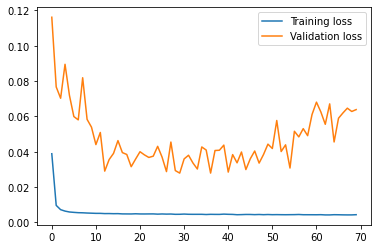

In [32]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [33]:
dates = pd.to_datetime(df['Date'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods = 10, freq = 'b').tolist()

In [34]:
n_day = 10
forecast = model.predict(trainX[-n_day:])

In [35]:
prediction_copies = np.repeat(forecast, df_close.shape[1], axis=-1)

In [43]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
y_pred_future

array([[6.527677 , 6.521215 , 6.5827446, 6.45636  ],
       [6.5454698, 6.5389915, 6.600742 , 6.473913 ],
       [6.4890633, 6.4826355, 6.5436864, 6.418265 ],
       [6.524522 , 6.5180626, 6.579553 , 6.453247 ],
       [6.514883 , 6.5084324, 6.569803 , 6.443738 ],
       [6.669627 , 6.6630383, 6.726328 , 6.5964017],
       [6.713099 , 6.706472 , 6.7703   , 6.63929  ],
       [6.819139 , 6.812417 , 6.87756  , 6.743904 ],
       [6.8498783, 6.843129 , 6.9086533, 6.7742305],
       [6.871444 , 6.8646755, 6.930467 , 6.795506 ]], dtype=float32)

In [40]:
forecast_dates = []
for time_i in predict_dates:
    forecast_dates.append(time_i.date())

In [41]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Adj Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

ValueError: Data must be 1-dimensional

In [ ]:
df_forecast

In [ ]:
df_2021 = data.DataReader('abev3.sa', 'yahoo', '2012-01-01', '2021-09-22')
#df_2021 = df[ (df['data_pregao'] > '2021-01-01')]
df_2021['data_pregao'] = df_2021.index
df_2021_close = df_2021[['data_pregao', 'Adj Close']]
df_2021_close = df_2021_close.set_index(pd.DatetimeIndex(df_2021_close['data_pregao'].values))
# df_2021_close.drop('data_pregao', axis= 1, inplace=True)
df_2021_close

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(x=df_2021_close['data_pregao'], y=df_2021_close['Adj Close'], name = 'real')])
fig.add_scatter(x=df_forecast['Date'], y=df_forecast['Adj Close'], mode='lines', name='predict')
fig.update_layout(barmode='group', hovermode='x')
fig.show()